# 拉格朗日多项式插值

拉格朗日插值法可以给出一个恰好穿过二维平面上若干个已知点的多项式函数。`scipy.interpolate.lagrange(x, y)`返回经过`(x, y)`所有点的多项式系数。

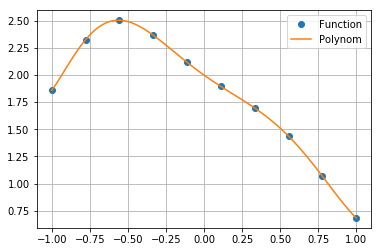

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import lagrange

def f(x):
    return (1 + np.exp(-x)) / (1 + x ** 4)

x = np.linspace(-1, 1, 10)
x2 = np.linspace(-1, 1, 100)
y = f(x)
p = lagrange(x, y)
plt.plot(x, f(x), "o", label="Function")
plt.plot(x2, np.polyval(p, x2), label="Polynom")
plt.legend(loc='upper right')
plt.grid();

下面是维基百科中关于拉格朗日多项式的说明:

给定 $k + 1$ 个数据点:

$$(x_0, y_0),\ldots,(x_j, y_j),\ldots,(x_k, y_k)$$

若$x_j$中没有重复值, 则拉格朗日插值的多项式是一个线性组合:

$$L(x) := \sum_{j=0}^{k} y_j \ell_j(x)$$

其中，

$$\ell_j(x) := \prod_{\begin{smallmatrix}0\le m\le k\\ m\neq j\end{smallmatrix}} \frac{x-x_m}{x_j-x_m} = \frac{(x-x_0)}{(x_j-x_0)} \cdots \frac{(x-x_{j-1})}{(x_j-x_{j-1})} \frac{(x-x_{j+1})}{(x_j-x_{j+1})} \cdots \frac{(x-x_k)}{(x_j-x_k)},$$

## 使用NumPy计算拉格朗日插值

下面使用NumPy的广播运算功能实现上述公式。在运算中将会出现三维数组，其各个轴的含义分别为：

* `i`: 进行插值运算的X轴坐标
* `j`: 与公式中$\ell_j(x)$对应的轴
* `m`: 与公式中$x_m$对应的轴

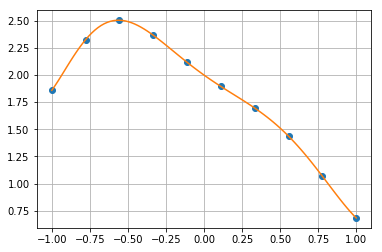

In [16]:
xi = np.linspace(-1, 1, 100)[:, None, None]
xj = x[None, :, None]
yj = y[None, :, None]
xm = x[None, None, :]
with np.errstate(divide='ignore', invalid='ignore'):
    ell = (xi - xm) / (xj - xm)
ell[~np.isfinite(ell)] = 1.0
ellj = ell.prod(axis=2, keepdims=True)
yi = (yj * ellj).sum(axis=1, keepdims=True)[:, 0, 0]

plt.plot(x, y, "o")
plt.plot(xi.squeeze(), yi)
plt.grid();

NumPy的广播功能虽然好用，但是需要我们记住每个轴对应的含义，并且在进行聚合运算需要设置`keepdims`参数为`True`。可以使用`xarray`简化该类运算。

## 使用`xarray`计算拉格朗日插值

`xarray`是对NumPy和Pandas的扩展。它提供的`DataArray`对象与NumPy的`ndarray`类似，但是可以对每个轴命名，并且设置标签。

在下面的运算中，我们分别创建沿着`i`, `j`, `m`轴的`DataArray`对象。在进行除法运算之前先通过`where()`方法将分母数组的对象线上的元素设置为`NaN`。在进行累乘运算时，通过`skipna=True`跳过`NaN`元素。

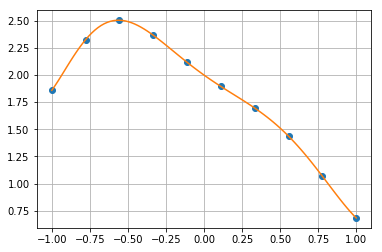

In [14]:
import xarray as xr

xi = xr.DataArray(np.linspace(-1, 1, 100), dims="i")
xm = xr.DataArray(x, dims="m")
xj = xr.DataArray(x, dims="j")
yj = xr.DataArray(y, dims="j")

ell = (xi - xm) / (xj - xm).where(xj.j != xm.m)
ellj = ell.prod(dim="m", skipna=True)
yi = (ellj * yj).sum(dim="j")

plt.plot(x, y, "o")
plt.plot(xi, yi)
plt.grid();